In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import io
import glob
import os

filename = "sm1.csv"
start_time = 	1718397770 # ~ 4:41PM on June 14
end_time = 1718554740 # ~ 12:19PM on June 16

df = pd.read_csv(filename)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# Remove all other columns so we can drop na
df = df[['Timestamp', 'Soil Moisture 1']]

# Resample
df = df.set_index('Timestamp')
df = df.loc[(df.index >= pd.to_datetime(start_time, unit='s')) & (df.index <= pd.to_datetime(end_time, unit='s'))]
df = df.resample('2T').mean()
df = df.reset_index()
df = df.dropna()

# output 3 spreadsheets, one per plant + one for soil + one for watering times
# merge guru1 (no plant)
# merge guru2 (plant)

input_dur = 'QTA\csvfiles'
no_plant_pattern = '*guru1\\.csv'
plant_pattern = '*guru2\\.csv'

no_plant_output = 'QTA\csvfiles\guru1.csv'
plant_output = 'QTA\csvfiles\guru2.csv'

no_plant_files = glob.glob(os.path.join(input_dur, no_plant_pattern))
plant_files = glob.glob(os.path.join(input_dur, plant_pattern))

dfs_no_plant = []
dfs_plant = []

for no_plant in no_plant_files :
    df_no_plant = pd.read_csv(no_plant)
    dfs_no_plant.append(df_no_plant)

for plant in plant_files :
    df_plant = pd.read_csv(plant)
    dfs_plant.append(df_plant)

merged_no_plant = pd.concat(dfs_no_plant, ignore_index=True)
merged_plant = pd.concat(dfs_plant, ignore_index=True)

merged_no_plant.to_csv(no_plant_output, ignore_index=False)
merged_plant.to_csv(plant_output, ignore_index=False)






: 

In [46]:
# make the index the number of hours since the start
df['Timestamp'] = df['Timestamp'] - df['Timestamp'].iloc[0]
df['Timestamp'] = df['Timestamp'].dt.total_seconds() / 3600


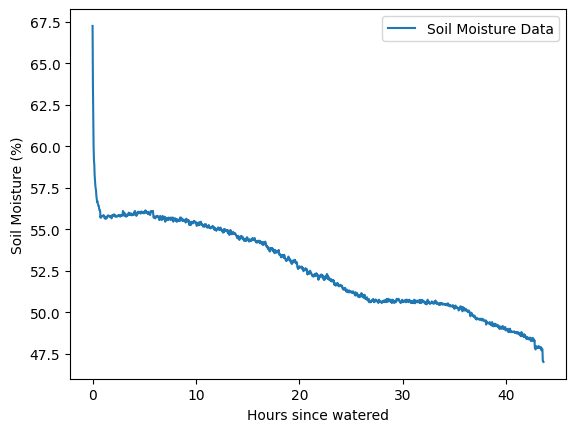

In [48]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['Timestamp'], df['Soil Moisture 1'], label='Soil Moisture Data')
plt.xlabel('Hours since watered')
plt.ylabel('Soil Moisture (%)')
#plt.ylim(0, 100)
plt.legend()
plt.show()

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


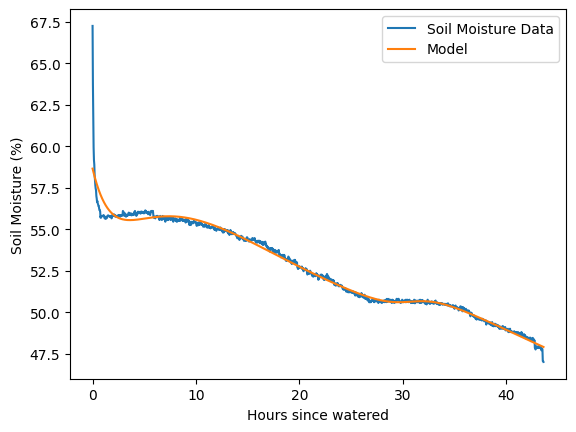

In [55]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def model(x, a, b, c):
    return a * np.exp(-b * x) + c

# 2 phase exp decay
def sigmoid_model(x, a1, b1, c1, a2, b2, c2, x0, k):
    return sigmoid(x, x0, k) * model(x, a1, b1, c1) + (1 - sigmoid(x, x0, k)) * model(x, a2, b2, c2)

# 3 phase exp decay
def double_sigmoid_model(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, x01, k1, x02, k2):
    return sigmoid(x, x01, k1) * model(x, a1, b1, c1) + (1 - sigmoid(x, x01, k1)) * sigmoid(x, x02, k2) * model(x, a2, b2, c2) + (1 - sigmoid(x, x02, k2)) * model(x, a3, b3, c3)

popt, pcov = curve_fit(double_sigmoid_model, df['Timestamp'], df['Soil Moisture 1'], p0=[100, 0.1, 0, 100, 0.1, 0, 100, 0.1, 0, 1, 1, 26, 1], maxfev=10000)

plt.figure()
plt.plot(df['Timestamp'], df['Soil Moisture 1'], label='Soil Moisture Data')
plt.plot(df['Timestamp'], double_sigmoid_model(df['Timestamp'], *popt), label='Model')
plt.xlabel('Hours since watered')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.show()
